# Homework 6: Bootstrapping to estimate parameter ranges of nonlinear models

***
### Academic honesty statement

**SANTIAGO ORTIZ LAVERDE**

- I state that I worked alone on this assignment. Therefore, I take full responsibility for the academic integrity of the work presented below.
***

# Bootstrapping to estimate parameter ranges of nonlinear models

When we first introduced ourselves to regression, we focused the regression algorithm’s ability to find the “truth”, i.e. how close to the true parameter values does the algorithm get.

In statistics and boostrapping, the truth is (typically) unknown and there is noise associated with any given measurement. So our question becomes “how confident am I that the parameters of my model are not zero?” And as discussed in class, all kinds of challenges arise when using bootstrapping. Here, we'll try a simple example.

Let's consider one of our equations for bacterial growth:
\begin{align}
\dot{y} = \frac{y^3}{a+y^3}-by
\end{align}

where y is the concentration of bacterium and a and b are parameters that help define the rate of bacterial growth and loss, respectively. 

You have been provided with data, called "Homework11 Data.csv". Use this data for the following excercises. In this file, you'll find the time points sampled and the concentration of bacterium (y) for 5 independent experiments. We will consider data to be independent across time and experiments.

## Part 1: Plot data and perform initial fitting

In the space below, load the data and write the code to fit the parameters of our model to the data using minimize or fsolve. You may want to revisit your previous homeworks. To make things a little easier, I'll give you the first guess for your parameter. Go with (a,b) = (0.3,0.8). After fitting:
   - clearly indicate what were the parameter values and the value of the cost function you implemented.
   - Plot on one plot the data and the fitted model's response

In [1]:
using CSV, DataFrames
using Plots, LaTeXStrings

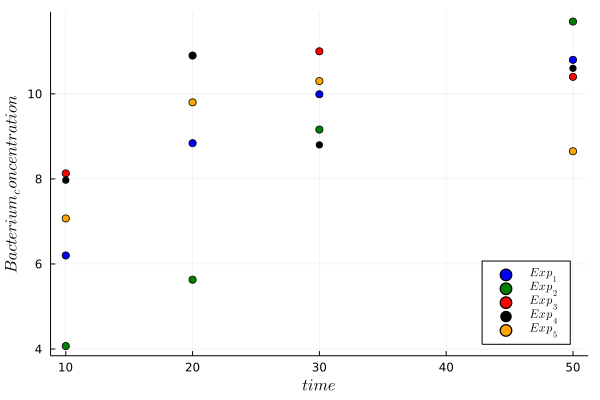

In [2]:
dat = CSV.read("Homework 6 Data.csv", DataFrame);
t = dat[!, :Time]
exp1 = dat[!, :Exp1]
exp2 = dat[!, :Exp2]
exp3 = dat[!, :Exp3]
exp4 = dat[!, :Exp4]
exp5 = dat[!, :Exp5]

plot(t, exp1, color=:blue, label=L"Exp_1", seriestype=:scatter)
plot!(t, exp2, color=:green, label=L"Exp_2", seriestype=:scatter)
plot!(t, exp3, color=:red, label=L"Exp_3",  seriestype=:scatter)
plot!(t, exp4, color=:black, label=L"Exp_4", seriestype=:scatter)
plot!(t, exp5, color=:orange, label=L"Exp_5",  seriestype=:scatter)
plot!(xlabel=L"time", ylabel=L"Bacterium_concentration", legend=:bottomright)

In [3]:
data = reduce(hcat, [t, exp1, exp2, exp3, exp4, exp5]);
time = []
Cbact = []
for j in range(1, size(data)[1])
    append!(time, ones(size(data)[2]-1)*t[j])
    append!(Cbact, data[j, 2:end])
end

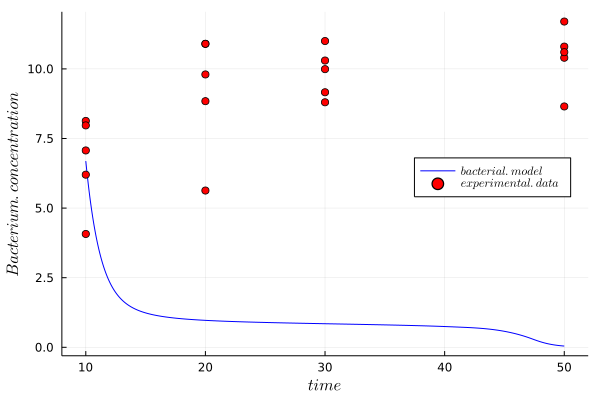

In [4]:
using DifferentialEquations
using Statistics

function bacterial_model!(du, u, p, t)
    a, b = p
    y = u[1]
    du[1] = dydt = y^3/(a + y^3) - b*y
end;

u0 = [mean(data[1, 2:end])]
tspan = (10.0, 50.0)
p = [0.3, 0.8]
prob = ODEProblem(bacterial_model!, u0, tspan, p)
sol = solve(prob, Tsit5());

plot(sol, label=L"bacterial.model", color=:blue)
plot!(time, Cbact, label=L"experimental.data", color=:red, seriestype=:scatter)
plot!(xlabel=L"time", ylabel=L"Bacterium.concentration", legend=:right, xlims=(8, 52))

In [5]:
using DiffEqParamEstim, Optim
# l2loss = L2Loss(time, Cbact, differ_weight=0.3, data_weight=0.7);
l2loss = L2Loss(time, Cbact);
cost_function = build_loss_objective(prob, Tsit5(), l2loss, maxiters=50000, verbose=false);

guess0 = [0.3, 0.8]
try1 = optimize(cost_function, guess0, Optim.NelderMead())
guess1 = Optim.minimizer(try1)
try2 = optimize(cost_function, guess1, Optim.LBFGS())
guess2 = Optim.minimizer(try2)
f = Optim.minimum(try2)
a = guess2[1]; b = guess2[2];

Parameter 'a' after fit is equal to 157.62568280809586 
Parameter 'b' after fit is equal to 0.08154187890105019 
The cost function value is equal to 40.9140244271213 


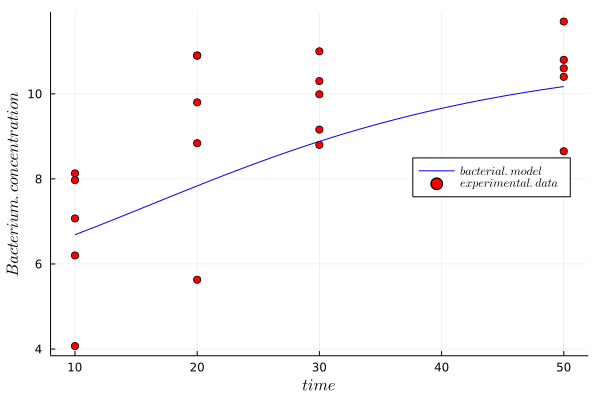

In [6]:
sol = solve(remake(prob; p=[a, b]), Tsit5());

printstyled("Parameter 'a' after fit is equal to $(a) \n"; color=:yellow)
printstyled("Parameter 'b' after fit is equal to $(b) \n"; color=:blue)
printstyled("The cost function value is equal to $(f) \n"; color=:red)

plot(sol, label=L"bacterial.model", color=:blue)
plot!(time, Cbact, label=L"experimental.data", color=:red, seriestype=:scatter)
plot!(xlabel=L"time", ylabel=L"Bacterium.concentration", legend=:right, xlims=(8, 52))

***